# Project 3

Import some libraries and the datasets

In [100]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_halving_search_cv # because it is experimental we need this
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from ISLP import load_data, confusion_table
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, log_loss, confusion_matrix, classification_report)
from sklearn.ensemble import (RandomForestRegressor, RandomForestClassifier)
from sklearn.inspection import permutation_importance
from sklearn.tree import export_graphviz
from IPython.display import Image, Markdown
import graphviz
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statistics
import re

In [2]:
# main dataset
data_index_2 = pd.read_csv('../Project_datasets/data_index_2.csv', quotechar="'")
data_index_2 = data_index_2.drop(columns=['Unnamed: 0'])
data_index_2.set_index(['Lon','Lat'])
# no idea what this is
#data_index_example = pd.read_csv('../Project_datasets/data_index - example.csv')
LPJ_GUESS_output = pd.read_csv('../Project_datasets/LPJ-GUESS_output_BERN1.csv')
# precipitation by day and statistics
Predaymean = pd.read_csv('../Project_datasets/Predaymean1961_1990.csv')
Predaymean_statistics = pd.read_csv('../Project_datasets/Predaymean1961_1990_statics.csv')
# maximum temperature by day and statistics
Tmaxdaymean = pd.read_csv('../Project_datasets/Tmaxdaymean1961_1990.csv')
Tmaxdaymean_statistics = pd.read_csv('../Project_datasets/Tmaxdaymean1961_1990_statics.csv')
# minimum temperature by day and statistics
Tmindaymean = pd.read_csv('../Project_datasets/Tmindaymean1961_1990.csv')
Tmindaymean_statistics = pd.read_csv('../Project_datasets/Tmindaymean1961_1990_statics.csv')
# mean temperature by day and statistics
Tmpdaymean = pd.read_csv('../Project_datasets/Tmpdaymean1961_1990.csv')
Tmpdaymean_statistics = pd.read_csv('../Project_datasets/Tmpdaymean1961_1990_statics.csv')
# shortwave radiation flux
Tswrfdaymean = pd.read_csv('../Project_datasets/Tswrfdaymean1961_1990.csv')
Tswrfdaymean_statistics = pd.read_csv('../Project_datasets/Tswrfdaymean1961_1990_statics.csv')

Text file

In [3]:
gridlist_pan_gfed_ISO3_UN = open('../Project_datasets/gridlist_pan_gfed_ISO3_UN.txt','r')

Show the first entries

### Main Data set

Short legend about the colums: 

Lon: Longitude<br>
Lat: Latidude

stuff about the souil texture: <br>

clay: Clay in %<br>
silt: Silt in % (sedimentary deposit that is formed when a river deposits the material it is carrying)<br>
slay: slay in %(soil in eg. rainforest) <br>
sand: sand in % %<br>
orC: organic carbondioxid in %<br>
CN: Cyanide in %<br>
pH: pH<br>
cell fraction: portion of cells / organic material in soil in % <br>


Allways with season: Same as the tables below.

tmax: maximum temperatur in K <br>
tmin: min temperature in K <br>
tmp:mean temperature in K <br>
Pre: Precipitation, mm day-1 <br>
tswrf: Total shortwave radiation flux, W m-2


This is the GUESS output: 

NPP: net primary productivity (kg C m-2 year-1)<br>
SoilR: soil respiration (kg C m-2 year-1)<br>
MaxBiomeCmass: The maximum biomass from a single biome (kg C m-2)<br>
MxbiomeLAI: The maximum leaf area index from a single biome (unitless)<br>
VegC: Vegetation carbon poo (kg C m-2)l<br>
LitterC: Litter carbon pool (kg C m-2)<br>
SoilC: Soil carbon pool (kg C m-2)<br>
Biome_Cmass: The biome type based on the maximum biomass (category)<br>
Biome_LAI: The biome type based on the maximum LAI (category)<br>
Biome_obs: The observed biome type (category)<br>

Country codes

GFED-region: Global Fire Emissions Database (https://www.un-spider.org/global-fire-emissions-database-gfed) <br>
Pan_2007: Big reogion (Europa, Africa, Australia, USA, Russia, China, .... )<br>
ISO3: Abbreviation for country <br>
UN: Country code

In [4]:
print(f'shape: {data_index_2.shape}')
data_index_2.head()

shape: (59191, 83)


,Lon,Lat,clay,silt,sand,orgC,CN,pH,cellfraction,tmax_SpringMean,...,VegC,LitterC,SoilC,Biome_Cmax,Biome_LAI,Biome_obs,GFED-region,Pan_2007,ISO3,UN
0,-179.75,71.25,0.08,0.37,0.55,0.020,11.0,5.9,0.482,249.88,...,0.0,0.000,0.000,13,13,17,10,Russia,RUS,643
1,-179.75,68.75,0.20,0.48,0.32,0.031,17.0,6.3,0.753,250.64,...,0.0,0.003,0.015,13,11,17,10,Russia,RUS,643
2,-179.75,68.25,0.20,0.48,0.32,0.031,17.0,6.3,0.447,249.84,...,0.0,0.006,0.022,13,11,17,10,Russia,RUS,643
3,-179.75,67.75,0.20,0.48,0.32,0.031,17.0,6.3,0.526,250.84,...,0.0,0.002,0.020,13,11,17,10,Russia,RUS,643
4,-179.75,67.25,0.20,0.48,0.32,0.031,17.0,6.3,0.422,251.42,...,0.0,0.003,0.016,13,11,17,10,Russia,RUS,643


In [5]:
with open("../Project_datasets/Readme.txt",'r') as script:
    speech = script.read().splitlines()

count = 1
for line in speech:
    if False:
        count+=1
        if count % 2 == 0: #this is the remainder operator
            print(line)
    else:
        print(line)

data information:
1. There are five climate variables which are daily average values during 1961-1990. They are Tswrf (Total shortwave radiation flux, W m-2), Pre (Precipitation, mm day-1), Tmp (Daily mean temperature, K), 
Tmax (Daily maximum temperature, K), and Tmin (Daily minimum temperature, K). 

2. In the file LPJ-GUESS_output BERN1.csv, the following variables are collected:
NPP: net primary productivity (kg C m-2 year-1)
SoilR: soil respiration (kg C m-2 year-1)
MaxBiomeCmass: The maximum biomass from a single biome (kg C m-2)
MxbiomeLAI: The maximum leaf area index from a single biome (unitless)
VegC: Vegetation carbon poo (kg C m-2)l
LitterC: Litter carbon pool (kg C m-2)
SoilC: Soil carbon pool (kg C m-2)
Biome_Cmass: The biome type based on the maximum biomass (category)
Biome_LAI: The biome type based on the maximum LAI (category)
Biome_obs: The observed biome type (category)

3. legend of biome

4. soilmap_center_interpolated.dat: the texture inforamtion for each grid ce

### LPJ_Guess_output


In [6]:
print(f'shape: {LPJ_GUESS_output.shape}')
LPJ_GUESS_output.head()

shape: (59191, 12)


,Lon,Lat,NPP,SoilR,MaxBiomeCmax,MaxBiomeLAI,VegC,LitterC,SoilC,Biome_Cmax,Biome_LAI,Biome_obs
0,39.75,-1.25,0.429,0.390,0.449,1.9821,1.225,0.758,5.941,8,12,12
1,150.25,-34.25,0.554,0.451,6.883,3.3174,6.953,3.221,10.566,7,7,6
2,-63.75,82.75,0.000,0.000,0.000,0.0000,0.000,0.003,0.002,13,13,17
3,59.25,30.75,0.043,0.042,0.090,0.2146,0.127,0.084,0.543,7,11,14
4,24.25,27.75,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,13,13,17


### Pred (Precipitation, mm day-1)
 

In [7]:
print(f'shape: {Predaymean.shape}')
Predaymean.head()

shape: (59191, 367)


,Lon,Lat,Day1,Day2,Day3,Day4,Day5,Day6,Day7,Day8,...,Day356,Day357,Day358,Day359,Day360,Day361,Day362,Day363,Day364,Day365
0,39.75,-1.25,0.634400,0.838580,1.373300,1.487800,0.948640,0.705560,0.790570,0.69274,...,1.260600,1.011600,2.676200,2.146300,0.83299,0.97611,1.092800,2.015100,1.220200,1.064100
1,150.25,-34.25,3.176800,3.282800,4.271300,2.735100,3.118300,1.863200,2.245400,1.81270,...,1.243100,2.901500,1.580400,2.788500,3.62270,2.12350,2.546700,2.624700,1.521800,2.259400
2,-63.75,82.75,0.191720,0.553370,0.559100,0.350270,0.414340,0.239620,0.215600,0.39415,...,0.286600,0.187410,0.352480,0.303120,0.37439,0.29827,0.399200,0.162680,0.180370,0.251560
3,59.25,30.75,0.272920,0.576200,1.529900,0.475970,0.809060,0.772860,0.773340,0.12219,...,0.315400,0.223630,0.009584,0.004932,0.65535,1.25430,0.680690,0.534400,0.225750,0.281360
4,24.25,27.75,0.012822,0.044511,0.027133,0.003318,0.007306,0.014162,0.085964,0.01347,...,0.029099,0.040272,0.030631,0.000518,0.00058,0.12653,0.010889,0.002139,0.003662,0.009687


In [8]:
print(f'shape: {Predaymean_statistics.shape}')
Predaymean_statistics.head()

shape: (59191, 14)


,Lon,Lat,SpringMean,SpringMedian,SpringStd,SummerMean,SummerMedian,SummerStd,FallMean,FallMedian,FallStd,WinterMean,WinterMedian,WinterStd
0,39.75,-1.25,0.870380,0.693390,0.641700,1.622500,1.30490,1.11930,0.528780,0.450650,0.315910,2.049600,1.836000,1.289100
1,150.25,-34.25,3.251700,2.971600,1.559000,2.418500,2.07100,1.51770,1.725700,1.331900,1.054600,2.547500,2.358200,1.253600
2,-63.75,82.75,0.234270,0.209640,0.139210,0.333730,0.31885,0.18320,0.758070,0.735040,0.338730,0.325480,0.296160,0.154960
3,59.25,30.75,0.715820,0.592520,0.423350,0.136010,0.03079,0.17825,0.005847,0.000000,0.020282,0.180990,0.045619,0.278850
4,24.25,27.75,0.045284,0.015422,0.070006,0.061916,0.01050,0.10039,0.004480,0.000016,0.022542,0.028823,0.006414,0.055641


### Tmp (Daily mean temperature, K)

In [9]:
print(f'shape: {Tmpdaymean.shape}')
Tmpdaymean.head()

shape: (59191, 367)


,Lon,Lat,Day1,Day2,Day3,Day4,Day5,Day6,Day7,Day8,...,Day356,Day357,Day358,Day359,Day360,Day361,Day362,Day363,Day364,Day365
0,39.75,-1.25,301.11,301.14,301.07,300.95,301.14,301.32,301.33,301.33,...,301.49,301.63,301.19,301.11,301.15,301.39,301.33,301.40,301.49,301.39
1,150.25,-34.25,293.59,293.28,293.53,292.33,292.28,292.75,292.78,293.84,...,293.04,292.88,292.75,293.03,292.37,292.62,293.36,292.90,293.58,292.72
2,-63.75,82.75,241.33,242.18,242.51,241.94,241.99,241.18,240.35,240.29,...,242.67,243.21,244.22,243.65,242.88,241.99,243.01,243.91,244.09,243.10
3,59.25,30.75,281.13,281.06,281.34,282.07,281.57,281.56,282.13,282.14,...,283.05,282.85,282.33,281.68,281.74,281.59,281.69,281.00,281.42,281.48
4,24.25,27.75,285.84,285.50,285.25,285.06,284.62,285.04,285.01,284.48,...,285.96,285.78,285.66,285.68,285.39,285.57,285.62,285.71,285.71,285.66


In [10]:
print(f'shape: {Tmpdaymean_statistics.shape}')
Tmpdaymean_statistics.head()

shape: (59191, 14)


,Lon,Lat,SpringMean,SpringMedian,SpringStd,SummerMean,SummerMedian,SummerStd,FallMean,FallMedian,FallStd,WinterMean,WinterMedian,WinterStd
0,39.75,-1.25,302.34,302.33,0.6554,301.21,301.20,1.3120,299.60,299.65,0.46193,301.42,301.39,0.44815
1,150.25,-34.25,292.82,292.97,1.1691,284.64,284.10,2.7774,282.29,281.50,1.80220,289.77,289.76,2.17460
2,-63.75,82.75,240.12,240.07,1.2096,260.31,261.44,10.1770,271.20,274.13,5.88880,247.77,245.76,4.80570
3,59.25,30.75,285.40,284.89,3.3975,299.63,300.13,4.0871,302.39,303.13,2.64690,288.71,287.35,4.84480
4,24.25,27.75,287.69,287.32,2.6203,299.53,299.15,2.9706,301.97,302.61,1.34370,291.17,290.75,4.37740


### Tmax

In [11]:
print(f'shape: {Tmaxdaymean.shape}')
Tmaxdaymean.head()

shape: (59191, 367)


,Lon,Lat,Day1,Day2,Day3,Day4,Day5,Day6,Day7,Day8,...,Day356,Day357,Day358,Day359,Day360,Day361,Day362,Day363,Day364,Day365
0,39.75,-1.25,302.63,302.91,302.83,302.43,302.76,302.99,302.95,303.04,...,302.96,303.14,302.65,302.49,302.66,302.87,302.73,302.76,302.99,302.98
1,150.25,-34.25,296.43,296.09,295.97,294.85,294.73,295.55,295.77,296.80,...,296.44,296.16,295.83,296.28,295.14,295.86,296.45,296.14,296.54,294.66
2,-63.75,82.75,244.72,245.60,245.89,245.11,244.98,244.50,243.61,243.90,...,246.04,246.82,247.53,247.26,246.58,246.02,246.67,247.49,247.69,246.57
3,59.25,30.75,284.75,284.92,285.61,286.23,285.53,285.78,286.21,285.91,...,287.97,288.04,287.38,286.80,287.24,287.00,286.86,286.56,286.61,286.65
4,24.25,27.75,290.05,289.76,289.50,289.10,289.05,289.41,289.26,288.84,...,290.04,289.73,289.58,289.62,289.48,289.77,289.97,290.24,290.17,289.90


In [12]:
print(f'shape: {Tmaxdaymean_statistics.shape}')
Tmaxdaymean_statistics.head()

shape: (59191, 14)


,Lon,Lat,SpringMean,SpringMedian,SpringStd,SummerMean,SummerMedian,SummerStd,FallMean,FallMedian,FallStd,WinterMean,WinterMedian,WinterStd
0,39.75,-1.25,304.27,304.43,0.74315,302.40,302.40,1.0318,301.13,301.11,0.39706,302.66,302.62,0.4142
1,150.25,-34.25,295.36,295.46,1.20660,288.11,287.64,3.0125,285.74,284.94,1.78200,293.06,293.14,2.1944
2,-63.75,82.75,243.87,243.72,1.14260,263.31,264.06,9.1992,272.13,274.69,5.69120,250.88,249.34,4.3383
3,59.25,30.75,288.82,287.81,3.27200,304.98,306.09,4.5394,307.99,308.63,2.57240,294.33,293.13,5.0202
4,24.25,27.75,291.96,291.66,2.65600,303.90,303.83,3.3008,306.28,306.87,1.23550,295.48,295.23,4.3877


### Tmin

In [13]:
print(f'shape: {Tmindaymean.shape}')
Tmindaymean.head()

shape: (59191, 367)


,Lon,Lat,Day1,Day2,Day3,Day4,Day5,Day6,Day7,Day8,...,Day356,Day357,Day358,Day359,Day360,Day361,Day362,Day363,Day364,Day365
0,39.75,-1.25,296.63,296.49,296.55,296.51,296.69,296.64,296.68,296.74,...,296.54,296.48,296.30,296.23,296.26,296.29,296.46,296.43,296.55,296.83
1,150.25,-34.25,290.14,289.85,289.86,288.98,288.74,289.37,289.22,290.43,...,289.51,289.81,289.54,289.99,289.32,289.53,290.06,289.90,290.14,289.41
2,-63.75,82.75,240.80,241.47,241.86,241.37,241.49,240.74,239.82,239.64,...,241.86,242.46,243.48,242.96,242.10,241.31,242.23,243.03,242.98,242.13
3,59.25,30.75,278.46,278.36,278.70,279.43,279.03,279.01,279.38,279.36,...,278.97,278.82,278.43,278.07,277.74,277.97,277.98,277.51,277.71,277.86
4,24.25,27.75,284.46,283.98,283.83,283.46,283.21,283.67,283.66,283.15,...,284.47,284.35,284.12,284.14,283.96,284.09,284.21,284.29,284.28,284.57


In [14]:
print(f'shape: {Tmindaymean_statistics.shape}')
Tmindaymean_statistics.head()

shape: (59191, 14)


,Lon,Lat,SpringMean,SpringMedian,SpringStd,SummerMean,SummerMedian,SummerStd,FallMean,FallMedian,FallStd,WinterMean,WinterMedian,WinterStd
0,39.75,-1.25,298.06,298.41,0.85947,297.03,297.02,0.77132,295.42,295.38,0.19342,296.47,296.48,0.32203
1,150.25,-34.25,288.99,289.28,1.23520,280.58,280.14,2.60160,278.59,277.94,2.10780,286.79,287.04,2.03760
2,-63.75,82.75,239.70,239.61,1.13850,259.44,260.53,10.01100,268.84,272.09,5.76450,246.56,244.91,4.44050
3,59.25,30.75,282.46,281.83,3.41820,297.17,298.07,3.95480,299.81,300.63,2.58780,285.18,283.81,5.08320
4,24.25,27.75,285.68,285.31,2.18730,296.19,296.15,2.91960,298.87,299.31,1.03790,289.35,289.10,4.03760


### Tswrf (Total shortwave radiation flux, W m-2)

In [15]:
print(f'shape: {Tswrfdaymean.shape}')
Tswrfdaymean.head()

shape: (59191, 367)


,Lon,Lat,Day1,Day2,Day3,Day4,Day5,Day6,Day7,Day8,...,Day356,Day357,Day358,Day359,Day360,Day361,Day362,Day363,Day364,Day365
0,39.75,-1.25,231.59,219.87,236.62,238.73,239.37,250.71,236.94,236.88,...,205.60,223.60,195.67,198.74,203.09,193.82,210.05,199.19,223.03,220.83
1,150.25,-34.25,306.97,311.71,310.55,311.11,311.43,304.95,312.76,312.54,...,305.95,301.99,296.33,301.22,287.30,293.39,301.39,296.81,296.34,279.91
2,-63.75,82.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,59.25,30.75,133.78,137.99,136.90,126.10,145.59,132.06,136.92,132.72,...,145.09,125.97,127.70,125.30,137.31,113.15,117.91,131.45,134.91,128.61
4,24.25,27.75,144.89,153.19,155.81,165.83,163.23,163.97,153.20,162.64,...,144.84,150.68,153.20,151.03,158.60,153.69,153.10,160.78,152.35,146.26


In [16]:
print(f'shape: {Tswrfdaymean_statistics.shape}')
Tswrfdaymean_statistics.head()

shape: (59191, 14)


,Lon,Lat,SpringMean,SpringMedian,SpringStd,SummerMean,SummerMedian,SummerStd,FallMean,FallMedian,FallStd,WinterMean,WinterMedian,WinterStd
0,39.75,-1.25,245.3500,243.31,12.278,224.76,223.69,14.020,212.13,209.70,17.828,230.61000,233.69,13.8210
1,150.25,-34.25,273.2400,280.66,31.715,143.77,134.31,30.976,168.57,159.00,40.282,277.94000,279.75,26.3640
2,-63.75,82.75,6.8325,0.00,14.407,214.38,238.73,68.931,140.85,142.78,85.973,0.43718,0.00,1.5824
3,59.25,30.75,176.1900,170.71,37.004,312.30,323.65,34.345,286.04,287.80,31.122,160.32000,153.34,34.7040
4,24.25,27.75,207.9700,200.82,38.315,308.44,311.95,20.496,302.93,307.45,23.021,189.10000,185.46,32.6170


### County List and binome legend

In [17]:
# Read the data from file into a list-of-lists table.
with open('../Project_datasets/gridlist_pan_gfed_ISO3_UN.txt') as file:
    datatable = [line.split() for line in file.read().splitlines()]

country_codes = pd.DataFrame(datatable, columns = ['Lon', 'Lat', 'GFED-region', 'Pan_2007', 'ISO3', 'UN'] )  
country_codes = country_codes.drop(index = 0)
country_codes.head()

,Lon,Lat,GFED-region,Pan_2007,ISO3,UN
1,-69.75,-55.25,5,Americas,CHL,152
2,-69.25,-55.25,5,Americas,CHL,152
3,-71.25,-54.75,5,Americas,CHL,152
4,-70.75,-54.75,5,Americas,CHL,152
5,-70.25,-54.75,5,Americas,CHL,152


In [18]:
    
with open("../Project_datasets/legend of biomes.txt",'r') as script:
    speech = script.read().splitlines()

count = 1
for line in speech:
    if True:
        count+=1
        if count % 2 == 0: #this is the remainder operator
            print(line)
    else:
        print(line)

1 Boreal decid forest
2 Boreal ever forest
3 Temp/boreal mix fo.
4 Temp conifer forest
5 Temp decid forest
6 Temp broad ever fo.
7 Temp mixed forest
8 Trop season forest
9 Trop rain forest
10 Trop decid forest
11 Moist savannas
12 Dry savannas
13 Tall grassland
14 Dry grassland
15 Xeric wood/shrub
16 Arid shrub/steppe
17 Desert
18 Arctic/alpine tundra


## Section 2: Visualisation


In [19]:
print(data_index_2.describe())

                Lon           Lat          clay          silt          sand  \
count  59191.000000  59191.000000  59191.000000  59191.000000  59191.000000   
mean      20.469932     30.797541      0.226424      0.280915      0.492662   
std       85.694107     31.484488      0.106558      0.109771      0.165724   
min     -179.750000    -55.250000      0.040000      0.050000      0.170000   
25%      -63.250000      7.750000      0.170000      0.200000      0.380000   
50%       30.250000     37.750000      0.230000      0.300000      0.450000   
75%       93.750000     57.250000      0.270000      0.330000      0.570000   
max      179.750000     83.250000      0.540000      0.610000      0.900000   

               orgC            CN            pH  cellfraction  \
count  59191.000000  59190.000000  59190.000000  59190.000000   
mean       0.022554     12.038250      6.329958      0.520901   
std        0.056028      2.444517      1.188566      0.167647   
min        0.002000      9.0

Countplot to count the number of data for each biom: 

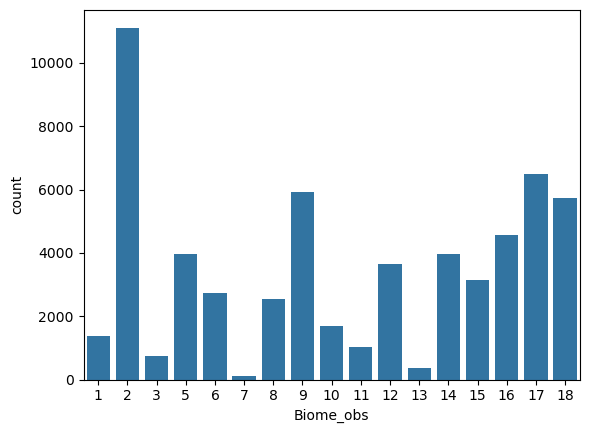

In [20]:
# create lineplot 
g = sns.countplot(data_index_2, x = "Biome_obs")

Scatter plott - Biome_LAI: The biome type based on the maximum LAI (category)

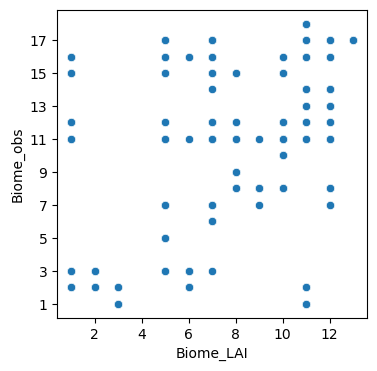

In [21]:
fig, ax = plt.subplots(figsize = (4,4))
ax = sns.scatterplot(data_index_2, x = "Biome_LAI", y = "Biome_obs")
ax.set_yticks(range(1, 18,2))

Scatterplott - Biome_Cmass: The biome type based on the maximum biomass (category)

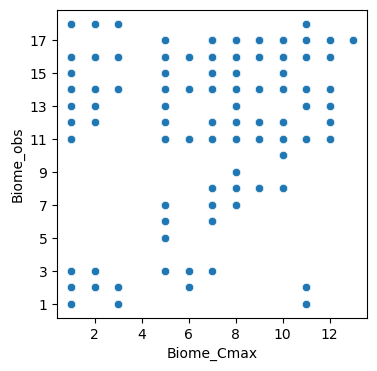

In [22]:
fig, ax = plt.subplots(figsize = (4,4))
ax = sns.scatterplot(data_index_2, x = "Biome_Cmax", y = "Biome_obs")
ax.set_yticks(range(1, 18,2))

<Axes: xlabel='Lon', ylabel='Lat'>

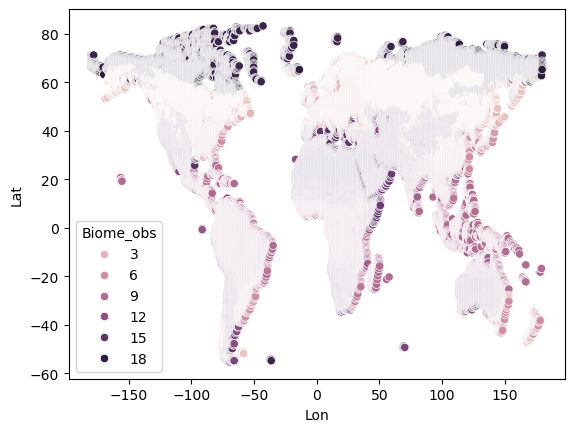

In [26]:
sns.scatterplot(data_index_2, x="Lon", y="Lat", hue="Biome_obs")

 ## Some preparations

### number of samples of different biomes in different coutries

In [32]:
countrys_sample_size = data_index_2.groupby(['ISO3', 'Biome_obs']).size()   ##### NOT TESTED
countrys_sample_size = pd.DataFrame(countrys_sample_size)
#countrys_sample_size.columns = [ "Size"]           # Maybe solve later
countrys_sample_size.head()

0
ISO3 Biome_obs     
AGO  6            3
     8          187
     9           25
     10          88
     11           7

In [34]:
# Samply size for countries
countrys_sample_size.loc["EGY"]


,0
Biome_obs,
14,34
16,34
17,292


## Section 3: Binary classification

We saw that `NaN` appeard somewhere in `data_index_2`. The following is to find out where it occurs.

In [35]:
print(list(data_index_2.loc[:,data_index_2.isna().any()]))
data_index_2[data_index_2.isna().any(axis=1)]

['CN', 'pH', 'cellfraction']


,Lon,Lat,clay,silt,sand,orgC,CN,pH,cellfraction,tmax_SpringMean,...,VegC,LitterC,SoilC,Biome_Cmax,Biome_LAI,Biome_obs,GFED-region,Pan_2007,ISO3,UN
59182,179.75,71.25,0.08,0.37,0.55,0.02,NaN,NaN,NaN,249.45,...,0.0,0.0,0.001,13,13,17,0,[],[],0


Choose countries. Random.org gave us the biomes
- 17: desert
- 16: Arid shrub/steppe

In [36]:
biome_list = [17,16] # our chosen biomes

Countplot: 

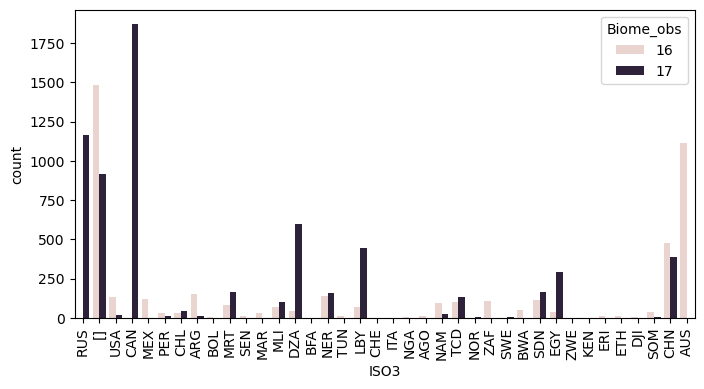

In [37]:
relevant_data = data_index_2.loc[data_index_2['Biome_obs'].isin(biome_list)]
relevant_data = relevant_data[~(relevant_data.isna().any(axis=1))] # delete rows with NaN
fig, ax = plt.subplots(figsize = (8,4))
ax = sns.countplot( relevant_data, x = 'ISO3', hue = 'Biome_obs')
ax.tick_params(axis='x', rotation=90)

Thus we choose Egypt to train and China as test.

In [38]:
region_train = data_index_2['ISO3'] == 'EGY' # egypt is the chosen one
region_test = data_index_2['ISO3'] == 'CHN' # china is the chosen one

Here the action starts.

In [89]:
# the following function generates X_test, Y_test and X_train, Y_train for the binary classification
def model_create_XY(drop_columns=[], region_train=region_train, region_test=region_test, \
                     objective_list=biome_list, use_columns=None, objective='Biome_obs', objective46 = 'Biome_Cmax'):
      # restrict to two biomes, restrict to country codes, remove any rows with NaN
      relevant_data = data_index_2
      relevant_data = relevant_data.loc[data_index_2[objective].isin(objective_list)] # restrict given biomes
      relevant_data = relevant_data[~(relevant_data.isna().any(axis=1))] # delete rows with NaN
      relevant_data_train = relevant_data.loc[region_train] # restrict to training country
      relevant_data_test = relevant_data.loc[region_test] # restrict to test country

      # TODO: drop meadian (as it is close to mean)
      drop_columns += ['MaxBiomeLAI','Biome_obs','Biome_LAI','Biome_Cmax',
                       'Lon','Lat','Pan_2007','ISO3','UN','MaxBiomeCmax'] # drop these columns
      if use_columns:
            X_train = relevant_data_train[use_columns]
            X_test = relevant_data_test[use_columns]
      else:
            X_train = relevant_data_train.drop(columns=drop_columns)
            X_test = relevant_data_test.drop(columns=drop_columns)

      feature_names = list(X_train.columns)

      Y_train = relevant_data_train[objective] # give True if it is the first biome in the list
      Y_test = relevant_data_test[objective] # give True if it is the first biome in the list
      
    
      # test data for task 4.6
      Y_test46 = relevant_data_test[objective46]
    


      print(f"length of training data: {Y_train.shape[0]}")
      print(f"length of testing data: {Y_test.shape[0]}")
    
      # print test data for task 4.6
      print(f"length of testing46 data: {Y_test46.shape[0]}")

      return X_train, X_test, Y_train, Y_test, Y_test46, feature_names

Function for plotting (Permutation importance vs. purity importance)

In [90]:
def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=2)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

Binary classification model

In [106]:
# the following generates, trains and evaluates the model
def model_train_evaluate(X_train, X_test, Y_train, Y_test, Y_test46, feature_names, hyperparameter_tuning=True):

    clf = RandomForestClassifier(random_state=0)
    
    if hyperparameter_tuning:
        X_hyper, Y_hyper = X_train, Y_train
        # X_hyper,_,Y_hyper,_ = skm.train_test_split(X_train, Y_train, train_size=300,random_state=0)
        # TODO: improve on this
        kfold3 = skm.KFold(3,
                        random_state=1,
                        shuffle=True) # let's try fewer fold to save running time

        fineness = 4 # determines how many parameters should be tested
        params = {
                'max_depth': np.linspace(5, 15, fineness).astype('int'),
                'n_estimators': np.linspace(10, 40, fineness).astype('int'), # CV number of trees, keep this low for part 4
                'min_samples_leaf': np.linspace(1, 5, fineness).astype('int'), # minimum leaf number
                }
        if False:
            rfc_gscv = GridSearchCV(clf, param_grid = params, scoring = "accuracy",
                                        cv = kfold3 )
        else:
            # Alternatively use HalvingGridSearchCV which is equally abismal in its performance
            rfc_gscv = HalvingGridSearchCV(clf, param_grid = params, scoring = "accuracy",
                                        cv = kfold3, min_resources=20, max_resources=30)
        
        # Fit the model
        model_rfc = rfc_gscv.fit(X_hyper, Y_hyper)

        # Model best estimator
        max_depths=model_rfc.best_estimator_.get_params()["max_depth"]
        max_trees= model_rfc.best_estimator_.get_params()["n_estimators"]
        min_samples_leaf= model_rfc.best_estimator_.get_params()["min_samples_leaf"]
        max_cvs= rfc_gscv.best_score_
        print("Max Depth: ", max_depths)
        print("Max Trees: ",max_trees)
        print("Min Leafs: ",min_samples_leaf)
        print("Max CV: ",max_cvs)

        clf = RandomForestClassifier(random_state=0, max_depth=max_depths, n_estimators=max_trees, min_samples_leaf=min_samples_leaf)

    clf.fit(X_train, Y_train)


    # Some performance 
    score_rfc_train = accuracy_score(Y_train, clf.predict(X_train))
    print('Accuracy of RandomForestClassifier on train data: {:.4f}'.format(score_rfc_train))
    kfold = skm.KFold(3, random_state=1, shuffle=True)
    # This becomes computationally quite expensive for large training sets
    scores_rfc_val = cross_val_score(clf, X_train, Y_train, cv=kfold)
    print("Accuracy RandomForestClassifier on cross validation: %0.4f ( %0.2f)" % (scores_rfc_val.mean(), scores_rfc_val.std()))
    score_rfc_test = accuracy_score(Y_test, clf.predict(X_test))
    print('Accuracy of RandomForestClassifier on test data: {:.4f}'.format(score_rfc_test))
    
    ###### I thought about the following line but than I recogniced that clf.predict(X_test) gives the biome_obs again as predictions
    #score_rfc_test = accuracy_score(Y_test46, clf.predict(X_test))
    #print('Accuracy of RandomForestClassifier on test46 data: {:.4f}'.format(score_rfc_test))
    
    # confusion table
    display(Markdown('---\n The confusion table'))
    display(confusion_table(clf.predict(X_test),
                            Y_test))
    '''
    # calculate precission and recall:
    conftable = confusion_matrix(clf.predict(X_test), Y_test) # gives same results as confusion_table
    tp_and_fn = conftable.sum(0)
    for i in range(len(tp_and_fn)):
        if abs(tp_and_fn[i]) < 1e-10 :
            tp_and_fn[i] = -1 
    
    tp_and_fp = conftable.sum(1)
    for i in range(len(tp_and_fp)):
        if abs(tp_and_fp[i]) < 1e-10:
            tp_and_fp[i] = -1
          
    tp = conftable.diagonal()
    
    # Recall and precision (-0 if the sum of rows/ columns = 0)
    display(Markdown('---\n Recall: proportion classified as True/ False of all True/Falls (along collums)'))
    recall = tp / tp_and_fn    
    print('Recall:', recall)
    
    display(Markdown('---\n Precission: proportion that werre True/ False of all samples predicted as True/ falls (along rows)'))
    precision = tp / tp_and_fp        
    print('Precision:', precision)
    '''
    
    print(classification_report(Y_test, clf.predict(X_test), zero_division = np.nan))
    
    
    # display importance table
    display(Markdown('---\n The feature importance'))
    feature_imp = pd.DataFrame(
    {'importance':clf.feature_importances_},
    index=feature_names)
    display(feature_imp.sort_values(by='importance', ascending=False))
    
    '''
    # Plot Impurity-based vs. Permutation importance
    mdi_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
    # tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
    # tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
    mdi_importances.sort_values().plot.barh(ax=ax1)
    ax1.set_xlabel("Gini importance")
    plot_permutation_importance(clf, X_train, Y_train, ax2)
    ax2.set_xlabel("Decrease in accuracy score")
    fig.suptitle(
        "Impurity-based vs. permutation importances on multicollinear features (train set)"
    )
    _ = fig.tight_layout()
    '''
    display(Markdown('---'))

In [102]:
# run the training data, test data and the model
def model_run(drop_columns=[], region_train=region_train, \
               region_test=region_test, objective_list=biome_list, use_columns=None, \
                hyperparameter_tuning=False, objective='Biome_obs', objective46 = 'Biome_Cmax'):
    X_train, X_test, Y_train, Y_test, Y_test46, feature_names = model_create_XY(drop_columns, region_train, \
                        region_test, objective_list, use_columns, objective, objective46)

    model_train_evaluate(X_train, X_test, Y_train, Y_test, Y_test46, feature_names, hyperparameter_tuning)

In [103]:
model_run()

length of training data: 326
length of testing data: 867
length of testing46 data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9632 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9850


---
 The confusion table

Truth,16,17
Predicted,,
16,477,12
17,1,377


---
 Recall: proportion classified as True/ False of all True/Falls (along collums)

Recall: [0.99790795 0.96915167]


---
 Precission: proportion that werre True/ False of all samples predicted as True/ falls (along rows)

Precision: [0.97546012 0.9973545 ]
              precision    recall  f1-score   support

          16       0.98      1.00      0.99       478
          17       1.00      0.97      0.98       389

    accuracy                           0.99       867
   macro avg       0.99      0.98      0.98       867
weighted avg       0.99      0.99      0.98       867



---
 The feature importance

,importance
SoilR,0.119342
VegC,0.096762
tmp_FallMean,0.069502
Pre_SpringMedian,0.050491
NPP,0.046478
...,...
CN,0.000878
silt,0.000679
GFED-region,0.000266
orgC,0.000218


---

Some evaluation of the model.

And now run the model whilst removing the medians

In [50]:
features_median = [feature_name for feature_name in list(data_index_2) if feature_name[-6:]=='Median']
print(f'We dropped the features: {features_median}')

model_run(drop_columns=features_median)

We dropped the features: ['tmax_SpringMedian', 'tmax_SummerMedian', 'tmax_FallMedian', 'tmax_WinterMedian', 'tswrf_SpringMedian', 'tswrf_SummerMedian', 'tswrf_FallMedian', 'tswrf_WinterMedian', 'tmin_SpringMedian', 'tmin_SummerMedian', 'tmin_FallMedian', 'tmin_WinterMedian', 'tmp_SpringMedian', 'tmp_SummerMedian', 'tmp_FallMedian', 'tmp_WinterMedian', 'Pre_SpringMedian', 'Pre_SummerMedian', 'Pre_FallMedian', 'Pre_WinterMedian']
length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9632 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9919


---
 The confusion table

Truth,16,17
Predicted,,
16,477,6
17,1,383


---
 Recall: proportion classified as True/ False of all True/Falls (along collums)

Recall: [0.99790795 0.98457584]


---
 Precission: proportion that werre True/ False of all samples predicted as True/ falls (along rows)

Precission: [0.99790795 0.98457584]


---
 The feature importance

,importance
SoilR,0.143831
VegC,0.087635
NPP,0.069610
Pre_SpringMean,0.064470
tmp_FallMean,0.058189
Pre_WinterMean,0.048003
Pre_WinterStd,0.042217
tmin_FallMean,0.039417
tmp_SummerMean,0.034553
tswrf_WinterMean,0.031324


---

Let's see how important the weather is.

In [51]:
features_weather = [feature_name for feature_name in list(data_index_2) if \
                   re.search('Fall|Summer|Winter|Spring',feature_name)]
print(f'We dropped the features: {features_weather}')
display(Markdown('---'))

model_run(drop_columns=features_weather.copy())

We dropped the features: ['tmax_SpringMean', 'tmax_SpringMedian', 'tmax_SpringStd', 'tmax_SummerMean', 'tmax_SummerMedian', 'tmax_SummerStd', 'tmax_FallMean', 'tmax_FallMedian', 'tmax_FallStd', 'tmax_WinterMean', 'tmax_WinterMedian', 'tmax_WinterStd', 'tswrf_SpringMean', 'tswrf_SpringMedian', 'tswrf_SpringStd', 'tswrf_SummerMean', 'tswrf_SummerMedian', 'tswrf_SummerStd', 'tswrf_FallMean', 'tswrf_FallMedian', 'tswrf_FallStd', 'tswrf_WinterMean', 'tswrf_WinterMedian', 'tswrf_WinterStd', 'tmin_SpringMean', 'tmin_SpringMedian', 'tmin_SpringStd', 'tmin_SummerMean', 'tmin_SummerMedian', 'tmin_SummerStd', 'tmin_FallMean', 'tmin_FallMedian', 'tmin_FallStd', 'tmin_WinterMean', 'tmin_WinterMedian', 'tmin_WinterStd', 'tmp_SpringMean', 'tmp_SpringMedian', 'tmp_SpringStd', 'tmp_SummerMean', 'tmp_SummerMedian', 'tmp_SummerStd', 'tmp_FallMean', 'tmp_FallMedian', 'tmp_FallStd', 'tmp_WinterMean', 'tmp_WinterMedian', 'tmp_WinterStd', 'Pre_SpringMean', 'Pre_SpringMedian', 'Pre_SpringStd', 'Pre_SummerMean

---

length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9663 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9931


---
 The confusion table

Truth,16,17
Predicted,,
16,477,5
17,1,384


---
 Recall: proportion classified as True/ False of all True/Falls (along collums)

Recall: [0.99790795 0.98714653]


---
 Precission: proportion that werre True/ False of all samples predicted as True/ falls (along rows)

Precission: [0.99790795 0.98714653]


---
 The feature importance

,importance
SoilR,0.318373
VegC,0.194957
NPP,0.183975
SoilC,0.078456
LitterC,0.076630
clay,0.036141
cellfraction,0.027651
sand,0.025204
pH,0.017084
silt,0.014798


---

Apparently not important at all. Now lets see if the model works only with weather data.

In [52]:
print(f'We only use the features: {features_weather}')
display(Markdown('---'))

model_run(use_columns=features_weather)

We only use the features: ['tmax_SpringMean', 'tmax_SpringMedian', 'tmax_SpringStd', 'tmax_SummerMean', 'tmax_SummerMedian', 'tmax_SummerStd', 'tmax_FallMean', 'tmax_FallMedian', 'tmax_FallStd', 'tmax_WinterMean', 'tmax_WinterMedian', 'tmax_WinterStd', 'tswrf_SpringMean', 'tswrf_SpringMedian', 'tswrf_SpringStd', 'tswrf_SummerMean', 'tswrf_SummerMedian', 'tswrf_SummerStd', 'tswrf_FallMean', 'tswrf_FallMedian', 'tswrf_FallStd', 'tswrf_WinterMean', 'tswrf_WinterMedian', 'tswrf_WinterStd', 'tmin_SpringMean', 'tmin_SpringMedian', 'tmin_SpringStd', 'tmin_SummerMean', 'tmin_SummerMedian', 'tmin_SummerStd', 'tmin_FallMean', 'tmin_FallMedian', 'tmin_FallStd', 'tmin_WinterMean', 'tmin_WinterMedian', 'tmin_WinterStd', 'tmp_SpringMean', 'tmp_SpringMedian', 'tmp_SpringStd', 'tmp_SummerMean', 'tmp_SummerMedian', 'tmp_SummerStd', 'tmp_FallMean', 'tmp_FallMedian', 'tmp_FallStd', 'tmp_WinterMean', 'tmp_WinterMedian', 'tmp_WinterStd', 'Pre_SpringMean', 'Pre_SpringMedian', 'Pre_SpringStd', 'Pre_SummerMea

---

length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9509 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.5502


---
 The confusion table

Truth,16,17
Predicted,,
16,477,389
17,1,0


---
 Recall: proportion classified as True/ False of all True/Falls (along collums)

Recall: [0.99790795 0.        ]


---
 Precission: proportion that werre True/ False of all samples predicted as True/ falls (along rows)

Precission: [0.99790795 0.        ]


---
 The feature importance

,importance
Pre_SpringMedian,0.071748
Pre_WinterMean,0.066330
tmin_FallMedian,0.055103
Pre_SpringMean,0.054281
Pre_WinterStd,0.053840
tmp_FallMean,0.048556
tmp_FallMedian,0.040753
tswrf_WinterMedian,0.038230
Pre_WinterMedian,0.037585
tmp_SummerMedian,0.036044


---

## Section 4: Multiclass classification

As regions we chose:
- China for training
- Africa for testing

In [67]:
region_train_4 = data_index_2['Pan_2007'] == 'China'
region_test_4 = data_index_2['Pan_2007'] == 'Africa'

# these are the biomes that appear in the test region
biome_obs_list_4 = list(data_index_2.loc[region_test_4]['Biome_obs'].drop_duplicates())  # I changed refgion_train to region_test_4 since it did not make sence for me
print(biome_obs_list_4)
biome_cmax_list_4 = list(data_index_2.loc[region_test_4]['Biome_Cmax'].drop_duplicates())
print(biome_cmax_list_4)

[12, 16, 15, 17, 14, 10, 11, 8, 9, 6, 5, 7, 13]
[10, 12, 8, 9, 7, 11, 13, 5]


And now we run the simulation

In [107]:
model_run(region_train=region_train_4, region_test=region_test_4, objective_list=biome_obs_list_4, hyperparameter_tuning=True)

length of training data: 2902
length of testing data: 10164
length of testing46 data: 10164
Max Depth:  5
Max Trees:  30
Min Leafs:  1
Max CV:  0.611111111111111
Accuracy of RandomForestClassifier on train data: 0.8670
Accuracy RandomForestClassifier on cross validation: 0.8436 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.3191


---
 The confusion table

Truth,5,6,7,8,9,10,11,12,13,14,15,16,17
Predicted,,,,,,,,,,,,,
5,6,1,0,0,0,0,0,14,0,4,3,0,0
6,0,82,3,44,21,36,52,234,1,319,263,159,220
7,0,0,0,0,1,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,6,0,1161,1366,1051,179,666,4,306,362,448,37
10,0,0,0,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,0,0,0


              precision    recall  f1-score   support

           5       0.21      1.00      0.35         6
           6       0.06      0.90      0.11        91
           7       0.00      0.00       nan         3
           8        nan      0.00       nan      1206
           9       0.24      0.98      0.39      1388
          10        nan      0.00       nan      1087
          11        nan      0.00       nan       234
          12        nan      0.00       nan      1144
          13        nan      0.00       nan         5
          14        nan      0.00       nan      1213
          15       0.08      0.07      0.08       676
          16       0.23      0.22      0.23      1031
          17       1.00      0.73      0.84      2080

    accuracy                           0.32     10164
   macro avg       0.26      0.30      0.33     10164
weighted avg       0.51      0.32      0.49     10164



---
 The feature importance

,importance
VegC,0.100862
SoilR,0.067446
NPP,0.066027
Pre_SummerMedian,0.063830
tmp_SpringMedian,0.052437
...,...
silt,0.000045
tmin_SummerMean,0.000000
cellfraction,0.000000
pH,0.000000


---

This is relatively abysmal performance. Fiddling with the hyperparameters changes a lot though the
hyperparameter optimisation is far from optimal.

In [ ]:
model_run(region_train=region_train_4, region_test=region_test_4, \
          objective_list=biome_obs_list_4, hyperparameter_tuning=True, drop_columns=features_median)

Let's see what happens if we remove the entire weather data.

In [ ]:
model_run(region_train=region_train_4, region_test=region_test_4, \
          objective_list=biome_obs_list_4, hyperparameter_tuning=True, drop_columns=features_weather)

Wow, our performance just improved. Let's see what happens if we use only weather data.

In [ ]:
print(features_weather)
model_run(region_train=region_train_4, region_test=region_test_4, \
          objective_list=biome_obs_list_4, hyperparameter_tuning=True, use_columns=features_weather.copy())

Turns out the weather really does not play an important role. Let's see if the model works better at classifying 'Biome_Cmax'.

In [ ]:
model_run(region_train=region_train_4, region_test=region_test_4, objective='Biome_Cmax' ,objective_list=biome_cmax_list_4, hyperparameter_tuning=True)

Here we compare with LPJ-Guess.

## Section 5: Regression 